# Homework 4 - Applied ML

In [27]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from sklearn import linear_model
sns.set()
sns.axes_style("darkgrid")
flatui = ["#e74c3c", "#3498db", "#2ecc71", "#34495e", "#9b59b6", "#95a5a6"]
sns.set_palette(flatui)

## Some plotting functions before starting 

In [28]:
def plot_bar_box(x, y, data, xticklabels, ylabel, title):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax1 = sns.barplot(x=x, y=y, data=data, ax=ax[0])
    ax2 = sns.boxplot(x=x, y=y, data=data, ax=ax[1])
    ax1.set_xticklabels(xticklabels)
    ax2.set_xticklabels(xticklabels)
    ax1.set_ylabel(ylabel)
    ax2.set_ylabel(ylabel)
    ax1.set_title(title)
    ax2.set_title(title)
    plt.show()
        
def plot_distrib(data, column):
        fig, ax = plt.subplots(figsize=(16, 8))
        df_treat = data.query('treat == 1')[column]
        df_control = data.query('treat == 0')[column]
        sns.distplot(df_treat, color=flatui[0])
        sns.distplot(df_control, color=flatui[1])
        

def plot_histogram(data, x, y, hue, xticklabels, ylabel, title):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax1 = sns.barplot(x=x, y=y, hue=hue, data=data)
    ax1.set_xticklabels(xticklabels)
    ax1.set_ylabel(ylabel)
    ax1.set_title(title)
    ax1.legend()
    plt.show()

## Question 1 : Propensity score matching

### 1. A naive analysis

In [29]:
df = pd.read_csv('../lalonde.csv')
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


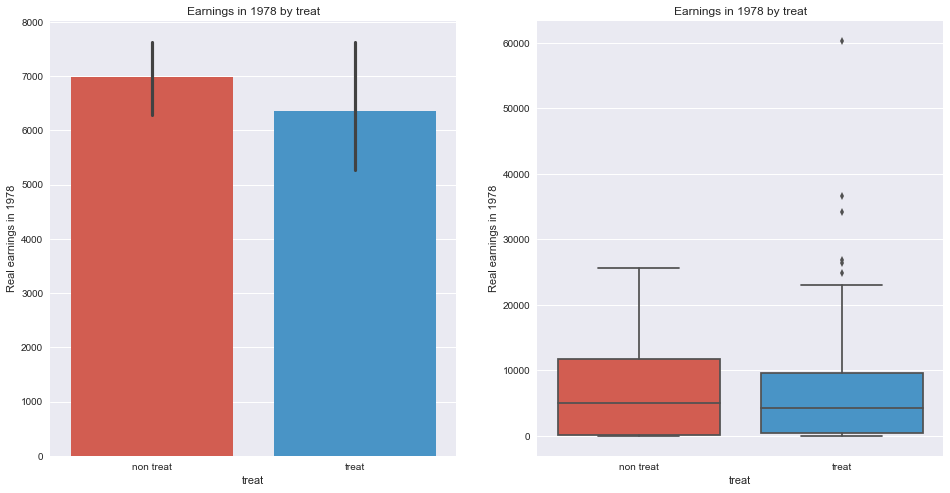

In [30]:
plot_bar_box('treat', 're78', df, ['non treat', 'treat'], 'Real earnings in 1978', 'Earnings in 1978 by treat')

#### Observations

As we can see from the bar and the box plots, the population who are *treated* has a lower income (except for a few outliers). <br>
A naïve researcher may conclude that the treatment is inneficient, as it diminishes the income of the participant. 
<br>
The treatment seems to have no effect to the outcome

### 2. A closer look at the data
Now, we want to compare the two groups by each variable to see if there are some differences.

#### By age

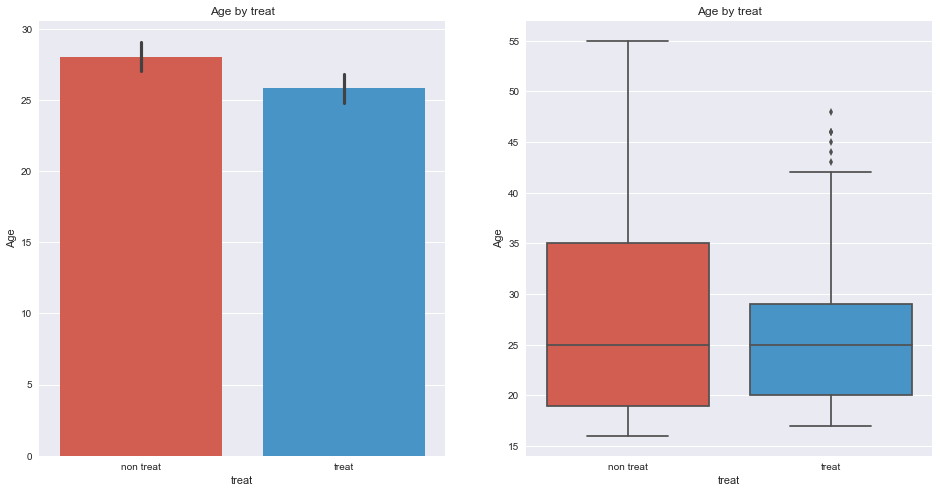

In [31]:
plot_bar_box('treat', 'age', df, ['non treat', 'treat'], 'Age', 'Age by treat')

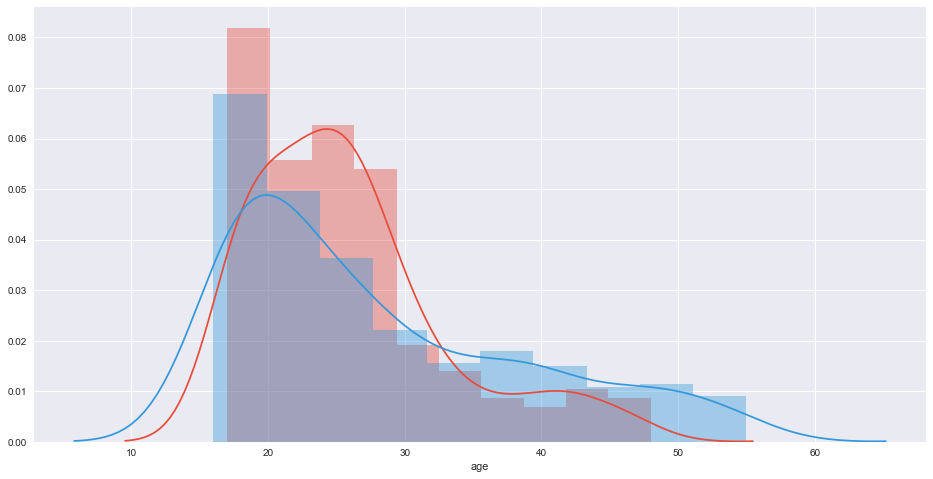

In [32]:
plot_distrib(df, 'age')

#### By years of education

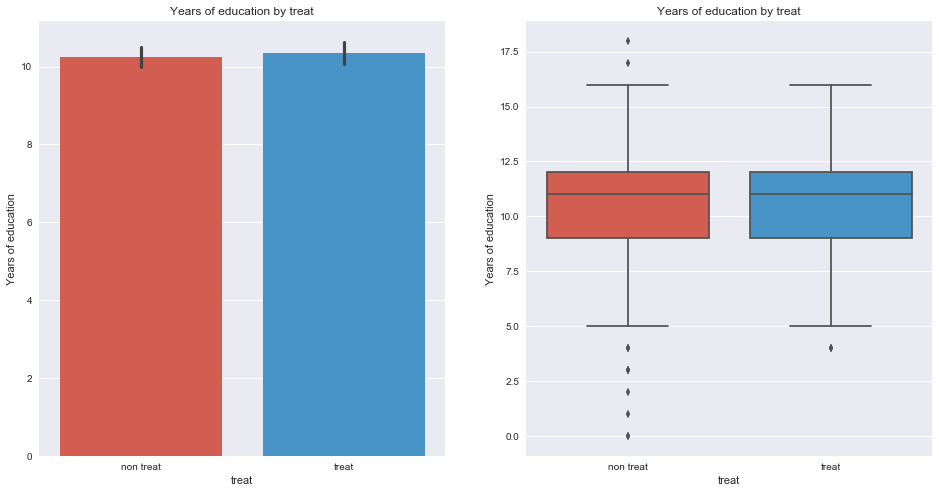

In [33]:
plot_bar_box('treat', 'educ', df, ['non treat', 'treat'], 'Years of education', 'Years of education by treat')

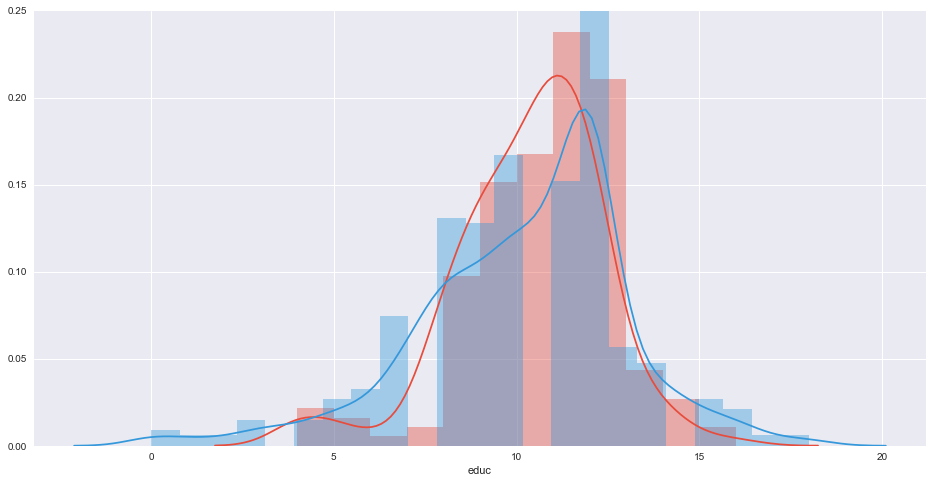

In [34]:
plot_distrib(df, 'educ')

#### By race

In [35]:
def get_ratio_feature(data, column):
    df_groups = data.groupby(['treat', column]).agg({'treat': 'count'})
    df_total = data.groupby(['treat']).agg({'treat': 'count'})
    df_ratio = df_groups.div(df_total) * 100
    df_ratio.columns = [column + ' %']
    df_ratio.reset_index(inplace=True)
    return df_ratio

In [36]:
df['race_str'] = 'white'
df.loc[df['black'] == 1, 'race_str'] = 'black'
df.loc[df['hispan'] == 1, 'race_str'] = 'hispan'

In [37]:
df_race_ratio = get_ratio_feature(df, 'race_str')

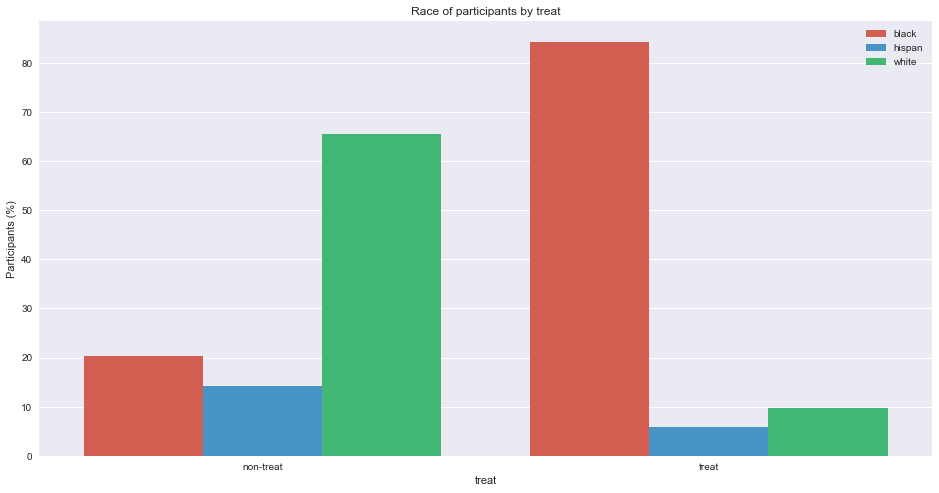

In [38]:
plot_histogram(df_race_ratio, 'treat', 'race_str %', 'race_str', ['non-treat', 'treat'], 'Participants (%)', 'Race of participants by treat')

#### By marital status

In [39]:
df['married_str'] = 'not married'
df.loc[df['married'] == 1, 'married_str'] = 'married'
df_married_ratio = get_ratio_feature(df, 'married_str')

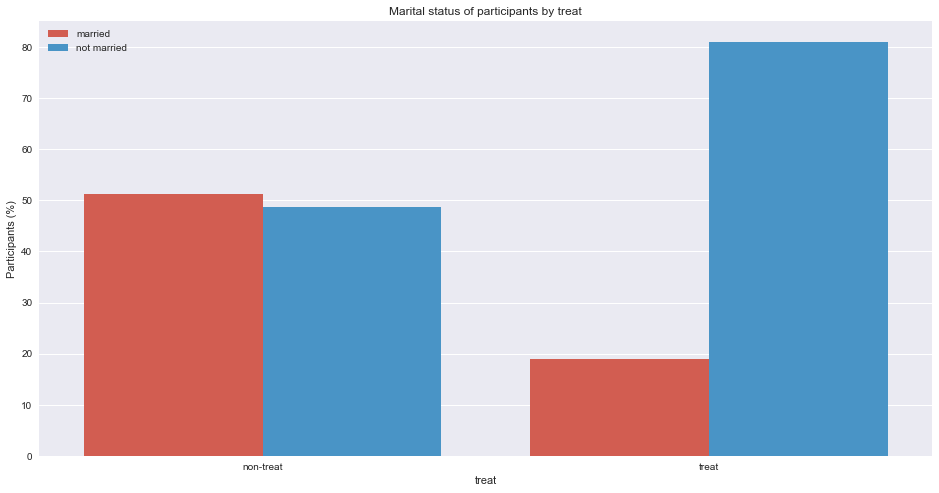

In [40]:
plot_histogram(df_married_ratio, 'treat', 'married_str %', 'married_str', ['non-treat', 'treat'], 'Participants (%)', 'Marital status of participants by treat')

#### By degree status

In [41]:
df['nodegree_str'] = 'have no degree'
df.loc[df['nodegree'] == 0, 'nodegree_str'] = 'have a degree'
df_degree_ratio = get_ratio_feature(df, 'nodegree_str')

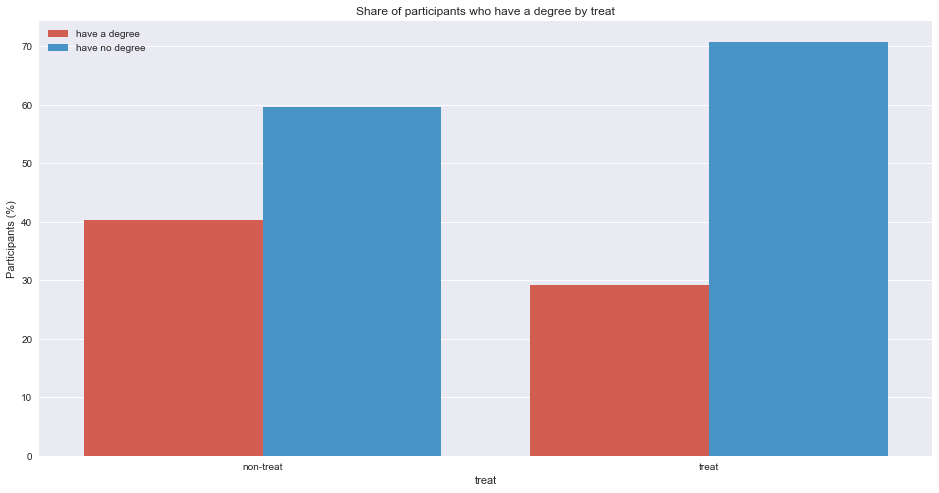

In [42]:
plot_histogram(df_degree_ratio, 'treat', 'nodegree_str %', 'nodegree_str', ['non-treat', 'treat'], 'Participants (%)', 'Share of participants who have a degree by treat')

#### Analysis of the evolution

In [43]:
df_evolution_nontreat = df.query('treat == 0')[['re74', 're75', 're78']]
df_evolution_treat = df.query('treat == 1')[['re74', 're75', 're78']]

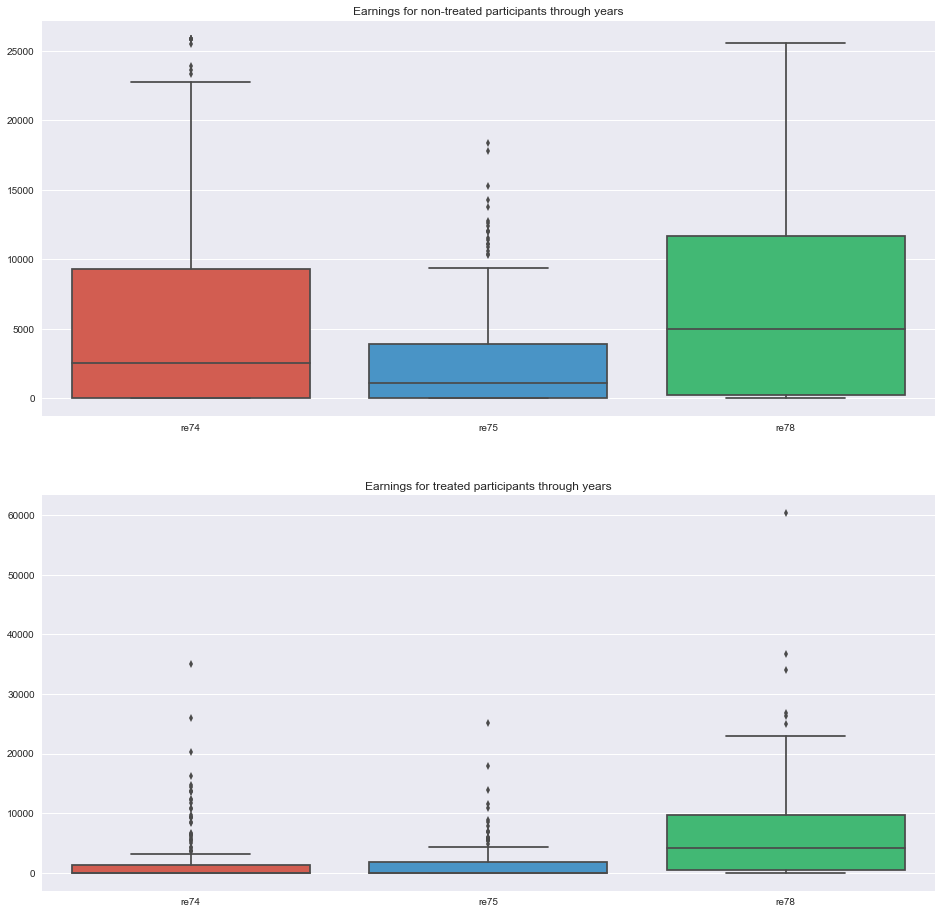

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(16, 16))
ax1 = sns.boxplot(data=df_evolution_nontreat, ax=ax[0])
ax1.set_title('Earnings for non-treated participants through years')
ax2 = sns.boxplot(data=df_evolution_treat, ax=ax[1])
ax2.set_title('Earnings for treated participants through years')
plt.show()

#### Observations and conclusion
It seems that the two groups (treat and control) dont come from the same distribution, it means that the naive interpretation is not acceptable.

### 3. A propsensity score model

Here, we run a logistic model in order to get prospensity scores, as we have seen in lecture.

In [45]:
def run_logistic_regression_model(data, label_column, feature_cols):
    logistic = linear_model.LogisticRegression()
    X = pd.get_dummies(data[feature_cols])
    y = data[label_column]
    logistic.fit(X, y)
    pred = logistic.predict_proba(X)
    return pred

In [46]:
predictions = run_logistic_regression_model(df, 'treat', ['age','educ','black','hispan','married','nodegree','re74','re75'])
df_propensity = df.copy()
df_propensity['propensity_score'] = predictions[:,1]

### 4. Balancing the dataset via matching

Before running graph with the max_weight_matching algorithm, we compute each distance between treat datapoints and control datapoints. We want minimizing distance, but here we use an algorithm that matches with the maximum, so we have to compute 1 -distance.

In [47]:
def run_graph_matching(data):
    df_treat = data.query('treat == 1')
    df_control = data.query('treat == 0')
    
    graph = nx.Graph()
    edges = [(id_x, id_y, {'weight': 1 - np.abs(x['propensity_score'] - y['propensity_score'])}) \
         for (id_x, x) in df_treat.iterrows() for (id_y, y) in df_control.iterrows()]
    graph.add_edges_from(edges)
    matching = nx.max_weight_matching(graph, maxcardinality=True)
    return matching, graph

In [48]:
matching, graph = run_graph_matching(df_propensity)

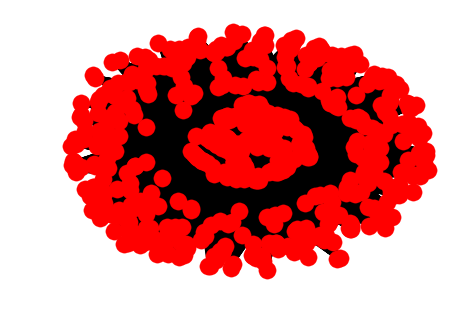

In [68]:
nx.draw(graph,pos=nx.spring_layout(graph)) # don't know if its cool
df_matched = df[df.index.isin(list(matching))]

In [70]:
# Verify same number in each groups
df_matched.groupby('treat')['id'].count()

treat
0    185
1    185
Name: id, dtype: int64

The treat is efficient as we can see here:

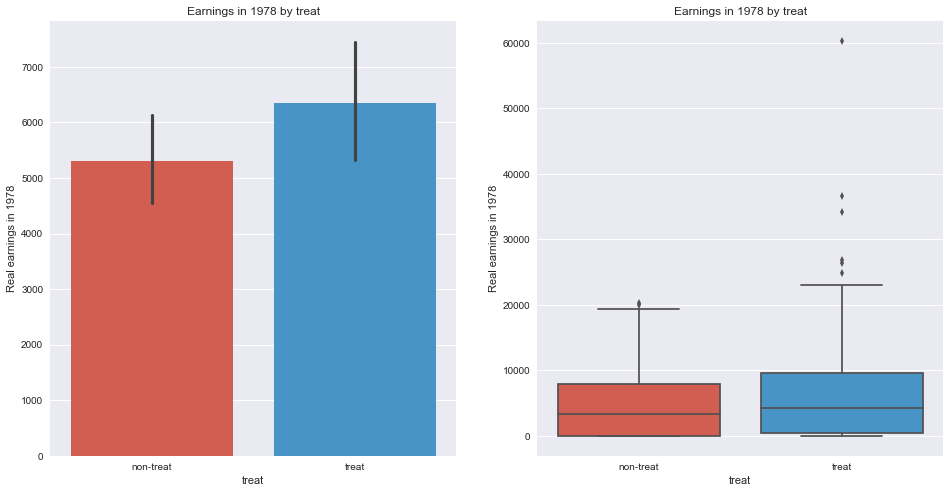

In [71]:
plot_bar_box('treat', 're78', df_matched, ['non-treat', 'treat'], 'Real earnings in 1978', 'Earnings in 1978 by treat')

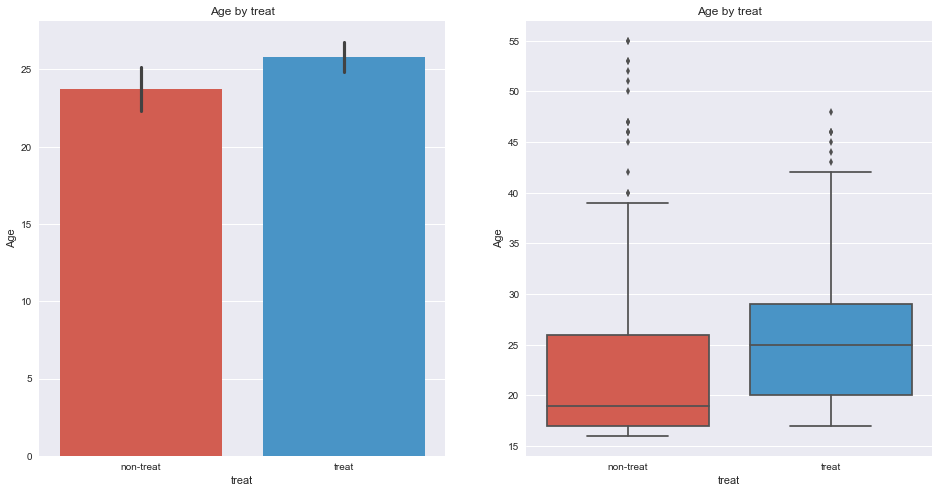

In [72]:
plot_bar_box('treat', 'age', df_matched, ['non-treat', 'treat'], 'Age', 'Age by treat')

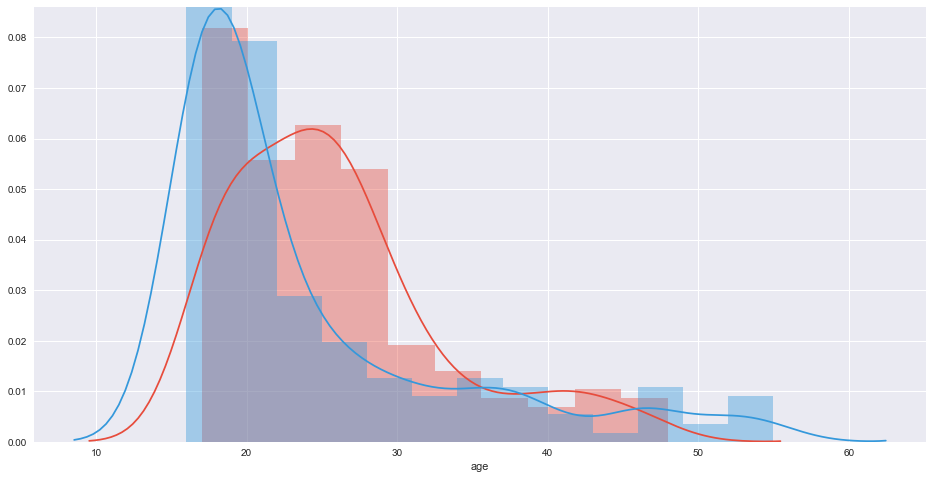

In [73]:
plot_distrib(df_matched, 'age')

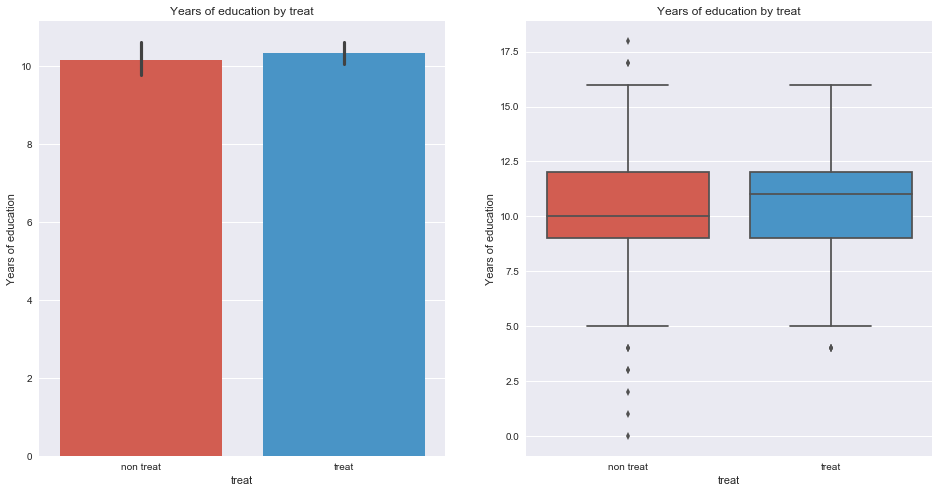

In [74]:
plot_bar_box('treat', 'educ', df_matched, ['non treat', 'treat'], 'Years of education', 'Years of education by treat')

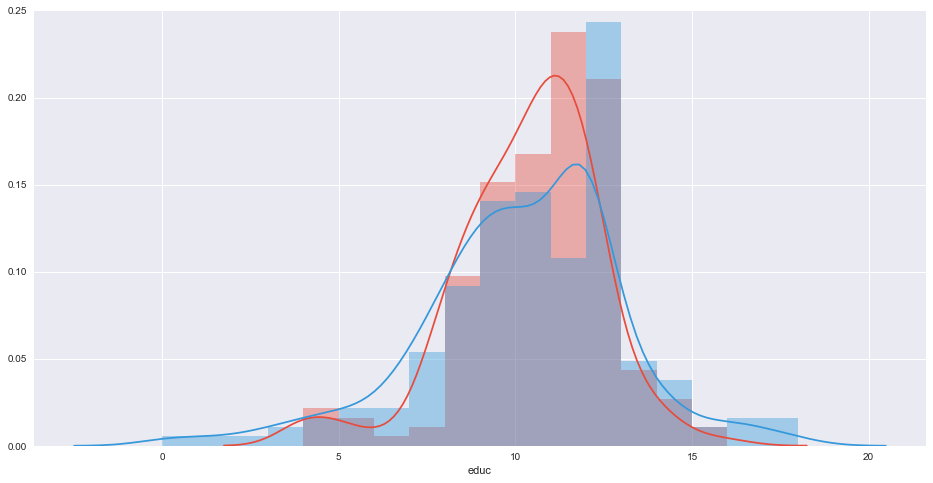

In [75]:
plot_distrib(df_matched, 'educ')

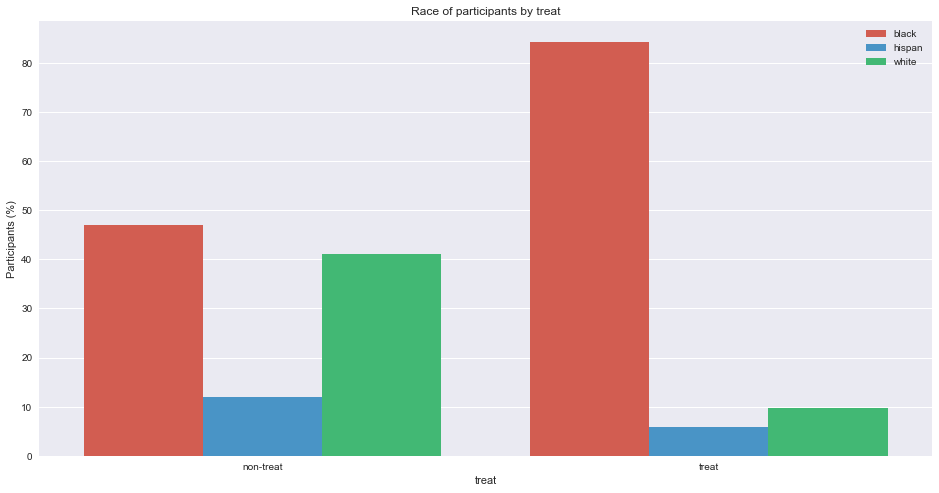

In [76]:
df_race_ratio = get_ratio_feature(df_matched, 'race_str')
plot_histogram(df_race_ratio, 'treat', 'race_str %', 'race_str', ['non-treat', 'treat'], 'Participants (%)', 'Race of participants by treat')

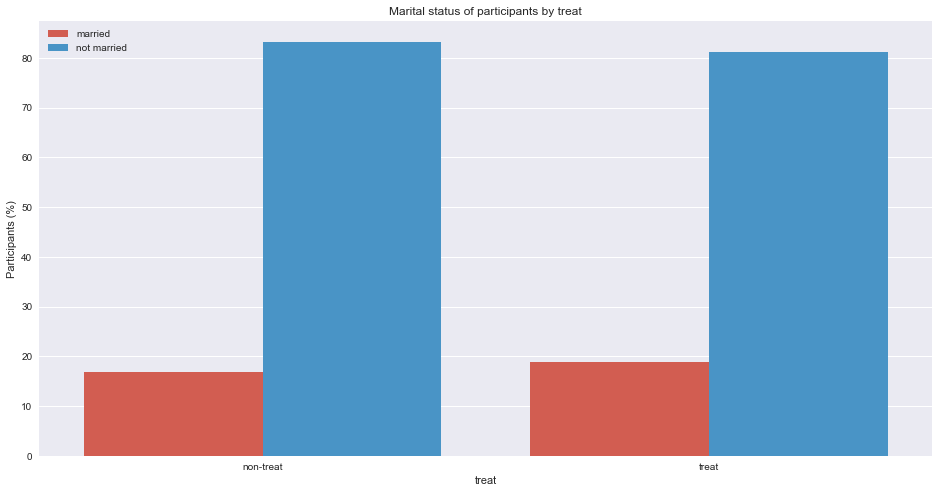

In [77]:
df_married_ratio = get_ratio_feature(df_matched, 'married_str')
plot_histogram(df_married_ratio, 'treat', 'married_str %', 'married_str', ['non-treat', 'treat'], 'Participants (%)', 'Marital status of participants by treat')

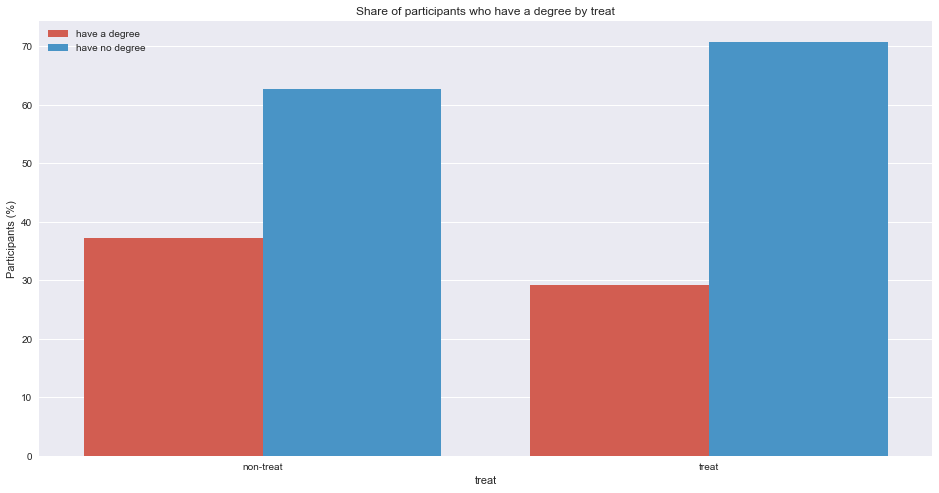

In [78]:
df_degree_ratio = get_ratio_feature(df_matched, 'nodegree_str')
plot_histogram(df_degree_ratio, 'treat', 'nodegree_str %', 'nodegree_str', ['non-treat', 'treat'], 'Participants (%)', 'Share of participants who have a degree by treat')

### 5. Balancing the groups further

Still more blacks on the control than in treat !<br>
Idea: run three different models for each race

In [79]:
# WHITE
df_white = df.copy().query('race_str == "white"')
predictions = run_logistic_regression_model(df_white, 'treat', ['age','educ','married','nodegree','re74','re75'])
df_white['propensity_score'] = predictions[:,1]
matching_white = run_graph_matching(df_white)[0]
df_matched_white = df_white[df_white.index.isin(list(matching_white))]

# BLACK
df_black = df.copy().query('race_str == "black"')
predictions = run_logistic_regression_model(df_black, 'treat', ['age','educ','married','nodegree','re74','re75'])
df_black['propensity_score'] = predictions[:,1]
matching_black = run_graph_matching(df_black)[0]
df_matched_black = df_black[df_black.index.isin(list(matching_black))]

# HISPAN
df_hispan = df.copy().query('race_str == "hispan"')
predictions = run_logistic_regression_model(df_hispan, 'treat', ['age','educ','married','nodegree','re74','re75'])
df_hispan['propensity_score'] = predictions[:,1]
matching_hispan = run_graph_matching(df_hispan)[0]
df_matched_hispan = df_hispan[df_hispan.index.isin(list(matching_hispan))]

frames = [df_matched_white, df_matched_black, df_matched_hispan]

df_matched_new = pd.concat(frames)

### 6. A less naive analysis

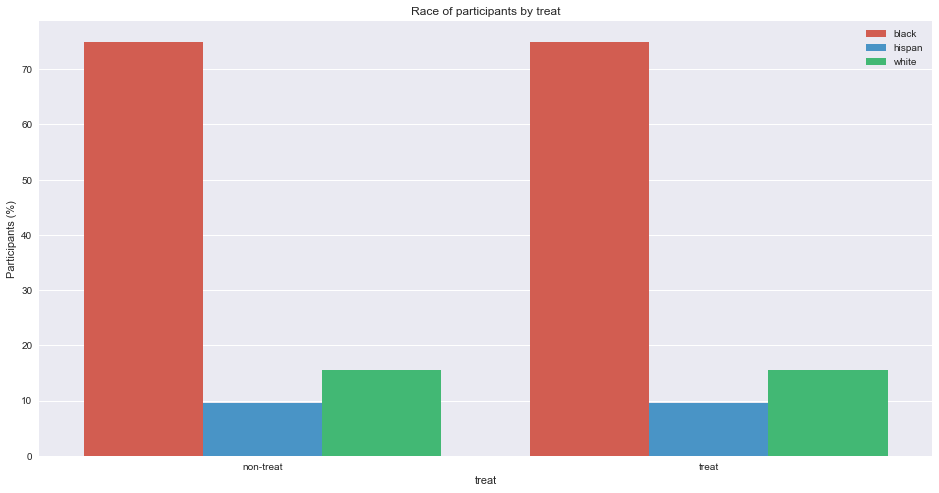

In [80]:
df_race_ratio = get_ratio_feature(df_matched_new, 'race_str')
plot_histogram(df_race_ratio, 'treat', 'race_str %', 'race_str', ['non-treat', 'treat'], 'Participants (%)', 'Race of participants by treat')

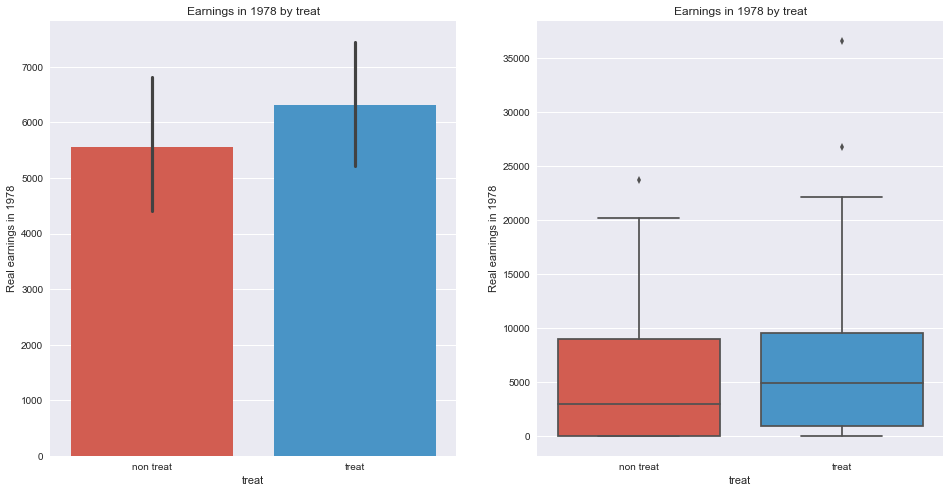

In [81]:
plot_bar_box('treat', 're78', df_matched_new, ['non treat', 'treat'], 'Real earnings in 1978', 'Earnings in 1978 by treat')

# Question 2: Applied ML

In [82]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [83]:
newsgroups = fetch_20newsgroups(data_home='20newsgroups', subset='all')

In [84]:
tfid = TfidfVectorizer()
vectors = tfid.fit_transform(newsgroups.data)

In [85]:
X = vectors
y = newsgroups.target

In [86]:
# 80% + 10% of training + validation together, then 0.1% of test
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=1, shuffle=True)

#ShuffleSplit will test 2 random splits with the validation set
s = ShuffleSplit(n_splits=2, test_size=0.1111, random_state=0)

In [87]:
param_grid = {
                 'n_estimators': np.arange(80, 100, 10),
                 'max_depth': [20]
             }

In [88]:
rfc = RandomForestClassifier()

In [89]:
rfc_gridsearch = GridSearchCV(rfc, param_grid=param_grid, verbose=2, cv=s)

This step take a bit of time... so we have stored the results in CSV file.<br>
**TODO: run by night in order to get the best hyperparameters**

In [ ]:
rfc_gridsearch.fit(X, y)
print(rfc_gridsearch.best_params_)
results = pd.DataFrame(rfc_gridsearch.cv_results_)
results.to_csv(path_or_buf='data/results_gridsearch.csv', encoding='utf8')

Now, we fit the best model to the training data. <br>
Then, we can predict the testing set using our model

In [90]:
rfc.set_params(n_estimators=100, max_depth=20)
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
y_pred = rfc.predict(X_test)
accuracy_score(y_pred, y_test)

0.78090185676392576

Now we get the classification report from scikit (TODO: read the documentation to explain)

In [92]:
print(classification_report(y_test, y_pred, target_names=newsgroups.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.87      0.71      0.78        78
           comp.graphics       0.72      0.62      0.67       101
 comp.os.ms-windows.misc       0.70      0.79      0.75        96
comp.sys.ibm.pc.hardware       0.71      0.70      0.71       110
   comp.sys.mac.hardware       0.87      0.68      0.77       101
          comp.windows.x       0.84      0.80      0.82       101
            misc.forsale       0.44      0.86      0.58        93
               rec.autos       0.88      0.80      0.84       109
         rec.motorcycles       0.91      0.93      0.92       103
      rec.sport.baseball       0.94      0.80      0.87       101
        rec.sport.hockey       0.87      0.96      0.91       110
               sci.crypt       0.85      0.92      0.88       104
         sci.electronics       0.60      0.47      0.52        79
                 sci.med       0.82      0.77      0.79        90
         

### Confusion matrix 
Then, we can plot the confusion matrix to evaluate the accuracy on the test set.

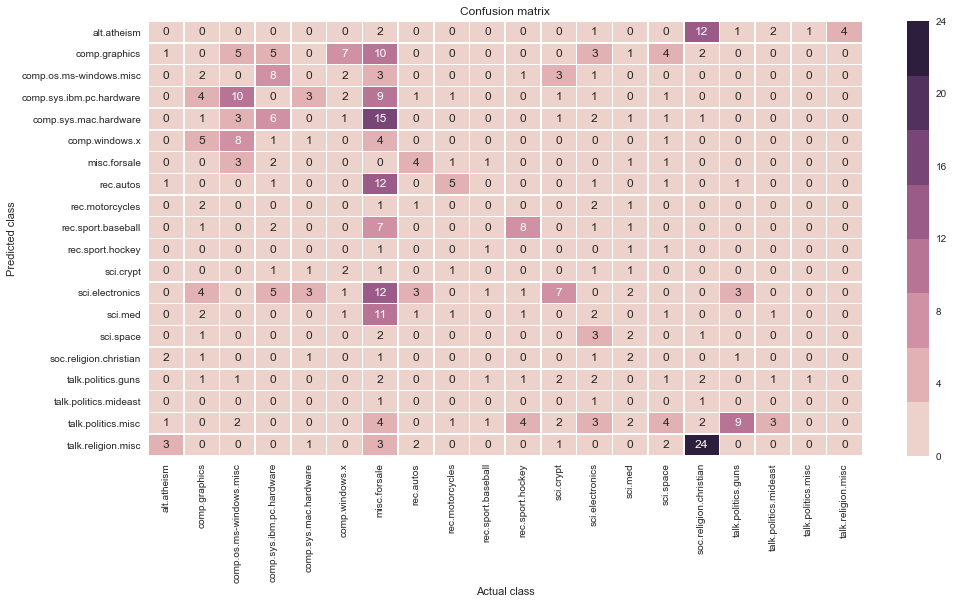

In [93]:
cm = confusion_matrix(y_test, y_pred)
np.fill_diagonal(cm, 0)

fig, ax = plt.subplots(1, figsize=(16, 8))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, xticklabels=newsgroups.target_names, yticklabels=newsgroups.target_names, cmap=sns.cubehelix_palette(8))
ax.set_title('Confusion matrix')
plt.xlabel('Actual class')
plt.ylabel('Predicted class')
plt.show()

### Feature importance

Let us represent the 20 most important features for the classification of the articles.

In [99]:
df_vocab = pd.DataFrame.from_dict(tfid.vocabulary_, orient='index')
df_vocab = df_vocab.reset_index().set_index(0, drop=True).sort_index()
df_vocab.columns = ['word']
df_vocab['importance'] = rfc.feature_importances_
df_vocab = df_vocab.sort_values('importance', ascending=False).head(20)

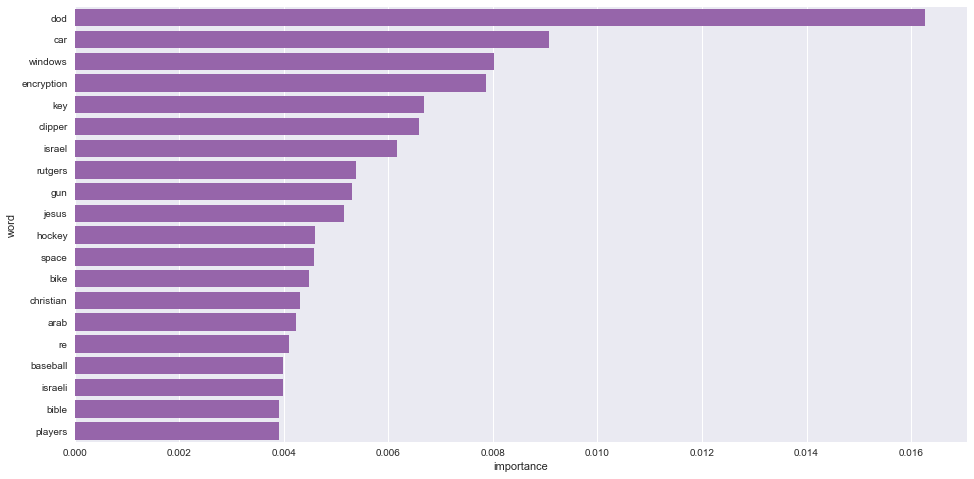

In [108]:
fig, ax = plt.subplots(1, figsize=(16, 8))
sns.barplot(x="importance", y="word", data=df_vocab, color='#9b59b6')

We can notice that we have a lot of randomness in the importance of words. It can be explained by the way the random forest trees were built, according the order of the articles were treated.